In [1]:
%matplotlib inline


분류기(Classifier) 학습하기
============================

지금까지 어떻게 신경망을 정의하고, 손실을 계산하며 또 가중치를 갱신하는지에
대해서 배웠습니다.

이제 아마도 이런 생각을 하고 계실텐데요,

데이터는 어떻게 하나요?
------------------------

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를
이용하여 NumPy 배열로 불러오면 됩니다. 그 후 그 배열을 ``torch.*Tensor`` 로 변환합니다.

-  이미지는 Pillow나 OpenCV 같은 패키지가 유용합니다.
-  오디오를 처리할 때는 SciPy와 LibROSA가 유용하고요.
-  텍스트의 경우에는 그냥 Python이나 Cython을 사용해도 되고, NLTK나 SpaCy도
   유용합니다.

특별히 영상 분야를 위한 ``torchvision`` 이라는 패키지가 만들어져 있는데,
여기에는 ImageNet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한
데이터 로더(data loader), 즉 ``torchvision.datasets`` 과 이미지용 데이터 변환기
(data transformer), 즉 ``torch.utils.data.DataLoader`` 가 포함되어 있습니다.

이러한 기능은 엄청나게 편리하며, 매번 유사한 코드(boilerplate code)를 반복해서
작성하는 것을 피할 수 있습니다.

이 튜토리얼에서는 CIFAR10 데이터셋을 사용합니다. 여기에는 다음과 같은 분류들이
있습니다: '비행기(airplane)', '자동차(automobile)', '새(bird)', '고양이(cat)',
'사슴(deer)', '개(dog)', '개구리(frog)', '말(horse)', '배(ship)', '트럭(truck)'.
그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가
3개 채널(channel)의 색상로 이뤄져 있다는 것을 뜻합니다.

v


이미지 분류기 학습하기
----------------------------

다음과 같은 단계로 진행해보겠습니다:

1. ``torchvision`` 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을
   불러오고, 정규화(nomarlizing)합니다.
2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용하여 신경망을 검사합니다.

1. CIFAR10을 불러오고 정규화하기


``torchvision`` 을 사용하여 매우 쉽게 CIFAR10을 불러올 수 있습니다.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다.
이를 [-1, 1]의 범위로 정규화된 Tensor로 변환합니다.

<div class="alert alert-info"><h4>Note</h4><p>만약 Windows 환경에서 BrokenPipeError가 발생한다면,
    torch.utils.data.DataLoader()의 num_worker를 0으로 설정해보세요.</p></div>



In [3]:
# 데이터 전처리  
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# cifar10 Dataset(train : 50000, test : )
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
print('Size of trainset : ', len(trainset))

# 데이터셋 감싸서 Loader에 load
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
print('Size of trainloader : ', len(trainloader))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
print('Size of testset : ', len(testset))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
print('Size of testloader : ', len(testloader))

# Class Categories(Labels)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Size of trainset :  50000
Size of trainloader :  12500
Files already downloaded and verified
Size of testset :  10000
Size of testloader :  2500


학습용 이미지 몇 개를 보겠습니다.



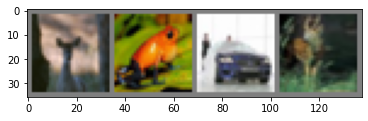

deer  frog  car   deer 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2. 합성곱 신경망(Convolution Neural Network) 정의하기  
 

3채널 이미지를 처리할 수 있도록 신경망을 수정합니다.



In [5]:
# GPU 학습 위해 device 지정
device = torch.device('cuda')
device

device(type='cuda')

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # in_channel, out_channels, kernel_size, stride, padding, ...
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

3. 손실 함수와 Optimizer 정의하기  

교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(momentum) 값을 갖는 SGD를 사용합니다.



In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. 신경망 학습하기  

이제 재미있는 부분이 시작됩니다.
단순히 데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)만 하면
됩니다.



In [8]:
for epoch in range(10):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = inputs.to(device), labels.to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.221
[1,  4000] loss: 1.866
[1,  6000] loss: 1.678
[1,  8000] loss: 1.585
[1, 10000] loss: 1.526
[1, 12000] loss: 1.495
[2,  2000] loss: 1.420
[2,  4000] loss: 1.380
[2,  6000] loss: 1.362
[2,  8000] loss: 1.343
[2, 10000] loss: 1.320
[2, 12000] loss: 1.298
[3,  2000] loss: 1.230
[3,  4000] loss: 1.225
[3,  6000] loss: 1.206
[3,  8000] loss: 1.202
[3, 10000] loss: 1.181
[3, 12000] loss: 1.197
[4,  2000] loss: 1.116
[4,  4000] loss: 1.112
[4,  6000] loss: 1.120
[4,  8000] loss: 1.125
[4, 10000] loss: 1.088
[4, 12000] loss: 1.118
[5,  2000] loss: 1.032
[5,  4000] loss: 1.029
[5,  6000] loss: 1.049
[5,  8000] loss: 1.043
[5, 10000] loss: 1.021
[5, 12000] loss: 1.069
[6,  2000] loss: 0.962
[6,  4000] loss: 0.976
[6,  6000] loss: 0.991
[6,  8000] loss: 0.993
[6, 10000] loss: 0.979
[6, 12000] loss: 0.988
[7,  2000] loss: 0.915
[7,  4000] loss: 0.914
[7,  6000] loss: 0.936
[7,  8000] loss: 0.952
[7, 10000] loss: 0.935
[7, 12000] loss: 0.974
[8,  2000] loss: 0.871
[8,  4000] 

학습한 모델을 저장해보겠습니다:



In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

PyTorch 모델을 저장하는 자세한 방법은   
<https://pytorch.org/docs/stable/notes/serialization.html>    
를 참조해주세요.  



5. 시험용 데이터로 신경망 검사하기 


지금까지 학습용 데이터셋을 2회 반복하며 신경망을 학습시켰습니다.
신경망이 전혀 배운게 없을지도 모르니 확인해봅니다.

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인합니다.
만약 예측이 맞다면 샘플을 '맞은 예측값(correct predictions)' 목록에 넣겠습니다.

첫번째로 시험용 데이터를 좀 보겠습니다.



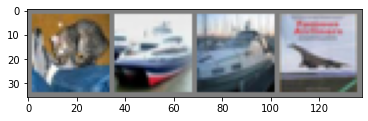

GroundTruth:  cat   ship  ship  plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# images, labels = images.to(device), labels.to(device)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

이제, 저장했던 모델을 불러오도록 하겠습니다 (주: 모델을 저장하고 다시 불러오는
작업은 여기에서는 불필요하지만, 어떻게 하는지 설명을 위해 해보겠습니다):



In [11]:
test_net = Net().to(device)
test_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

좋습니다, 이제 이 예제들을 신경망이 어떻게 예측했는지를 보겠습니다:



In [12]:
outputs = test_net(images.to(device))

출력은 10개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이
나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것입니다.
따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   truck plane


결과가 괜찮아보이네요.

그럼 전체 데이터셋에 대해서는 어떻게 동작하는지 보겠습니다.



In [14]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = test_net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


(10가지 분류 중에 하나를 무작위로) 찍었을 때의 정확도인 10% 보다는 나아보입니다.
신경망이 뭔가 배우긴 한 것 같네요.

그럼 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보겠습니다:



In [15]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = test_net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 69.5 %
Accuracy for class: car   is 67.1 %
Accuracy for class: bird  is 51.8 %
Accuracy for class: cat   is 30.9 %
Accuracy for class: deer  is 56.2 %
Accuracy for class: dog   is 57.3 %
Accuracy for class: frog  is 80.4 %
Accuracy for class: horse is 65.5 %
Accuracy for class: ship  is 78.2 %
Accuracy for class: truck is 60.2 %
